# The Goal of this notebook is to create a classifier for LEGO to buy or not

In [179]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb


import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [187]:
lego_df = pd.read_csv("clean_lego_data.csv")
model_df = lego_df.drop(columns=['Years','Unnamed: 0','set_num','Theme','Subtheme'])

In [188]:
model_df = model_df.set_index("Name")

In [189]:
model_df['Current_Sets_For_Sale'] = model_df['Current_Sets_For_Sale'].replace('[\$,]', '', regex=True).astype(int)

In [190]:
model_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6456 entries, Manual Control Set 1 to Weetabix Castle
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year_Released          6456 non-null   float64
 1   Availability           6456 non-null   object 
 2   Retail_Price           6456 non-null   float64
 3   Current_Value          6456 non-null   float64
 4   Current_Sets_For_Sale  6456 non-null   int64  
 5   Minifigs               6456 non-null   float64
 6   Duplo figures          6456 non-null   float64
 7   Price_Per_Piece        6456 non-null   float64
 8   id                     6456 non-null   int64  
 9   num_parts              6456 non-null   int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 554.8+ KB


In [191]:
model_df.Availability.value_counts()

Retired                         5064
Retired (Limited Retail)         528
Retail                           494
Retired (Exclusive)              317
Limited Retail                    26
Exclusive                         26
Retired (LEGOLAND Exclusive)       1
Name: Availability, dtype: int64

In [194]:
model_df = pd.get_dummies(model_df)
model_df = model_df.drop(columns=['Availability_Retired (Limited Retail)'])
model_df

,Year_Released,Retail_Price,Current_Value,Current_Sets_For_Sale,Minifigs,Duplo figures,Price_Per_Piece,id,num_parts,Availability_Exclusive,Availability_Limited Retail,Availability_Retail,Availability_Retired,Availability_Retired (Exclusive),Availability_Retired (LEGOLAND Exclusive)
Name,,,,,,,,,,,,,,,
Manual Control Set 1,1986.0,8.915822,112.97,159,0.0,0.0,0.193822,1,39,0,0,0,1,0,0
Storm Beast,2016.0,14.990000,71.65,10,0.0,0.0,0.137523,324,109,0,0,0,1,0,0
Quake Beast,2016.0,14.990000,67.50,10,0.0,0.0,0.146961,324,102,0,0,0,1,0,0
Umarak the Destroyer,2016.0,24.990000,109.00,10,0.0,0.0,0.130838,324,190,0,0,0,1,0,0
Sunshine Catamaran,2017.0,69.990000,69.99,15,3.0,0.0,0.116070,494,603,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tarix,2009.0,12.990000,59.50,6,0.0,0.0,0.227895,331,57,0,0,0,1,0,0
Strakk,2009.0,12.990000,45.00,6,0.0,0.0,0.282391,331,46,0,0,0,1,0,0
Vorox,2009.0,12.990000,90.07,6,0.0,0.0,0.254706,331,51,0,0,0,1,0,0


In [195]:
# S&P 500 is 9.8% annual growth rate 
# inflation is 3.5%

def invest(row):
    num_years = 2020 - int(row.Year_Released)
    inflation_rate = .035
    annual_return = .10 + inflation_rate
    min_growth = row.Retail_Price
    for i in range(num_years):
        min_growth += min_growth * annual_return
    if row.Current_Value > min_growth:
        return 1
    else:
        return 0

In [196]:
#df['NewCol'] = df.apply(lambda x: segmentMatch(x['TimeCol'], x['ResponseCol']), axis=1)

model_df['Invest'] = model_df.apply(lambda x: invest(x), axis=1)

In [197]:
model_df['Invest'].value_counts()

0    4553
1    1903
Name: Invest, dtype: int64

In [198]:
model_df['Year_Released'] = model_df['Year_Released'].astype(str)

In [199]:
model_df.describe()

,Unnamed: 0,Retail_Price,Current_Value,Minifigs,Duplo figures,Price_Per_Piece,id,num_parts,Invest
count,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000
mean,3239.724907,29.875213,138.664078,1.616636,0.114622,0.174626,339.050186,247.257435,0.294765
std,1873.185575,51.605745,421.132250,2.450380,0.589500,0.391543,210.917185,412.740922,0.455972
min,0.000000,0.000000,1.390000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1616.750000,5.490000,21.930000,0.000000,0.000000,0.087288,148.000000,43.000000,0.000000
50%,3239.500000,14.990000,50.050000,1.000000,0.000000,0.114647,347.000000,107.000000,0.000000
75%,4860.250000,34.990000,128.690000,2.000000,0.000000,0.181758,504.000000,291.000000,1.000000
max,6481.000000,799.990000,22184.580000,30.000000,7.000000,12.990000,688.000000,6020.000000,1.000000


In [200]:
model_df['id'] = model_df['id'].astype(str)

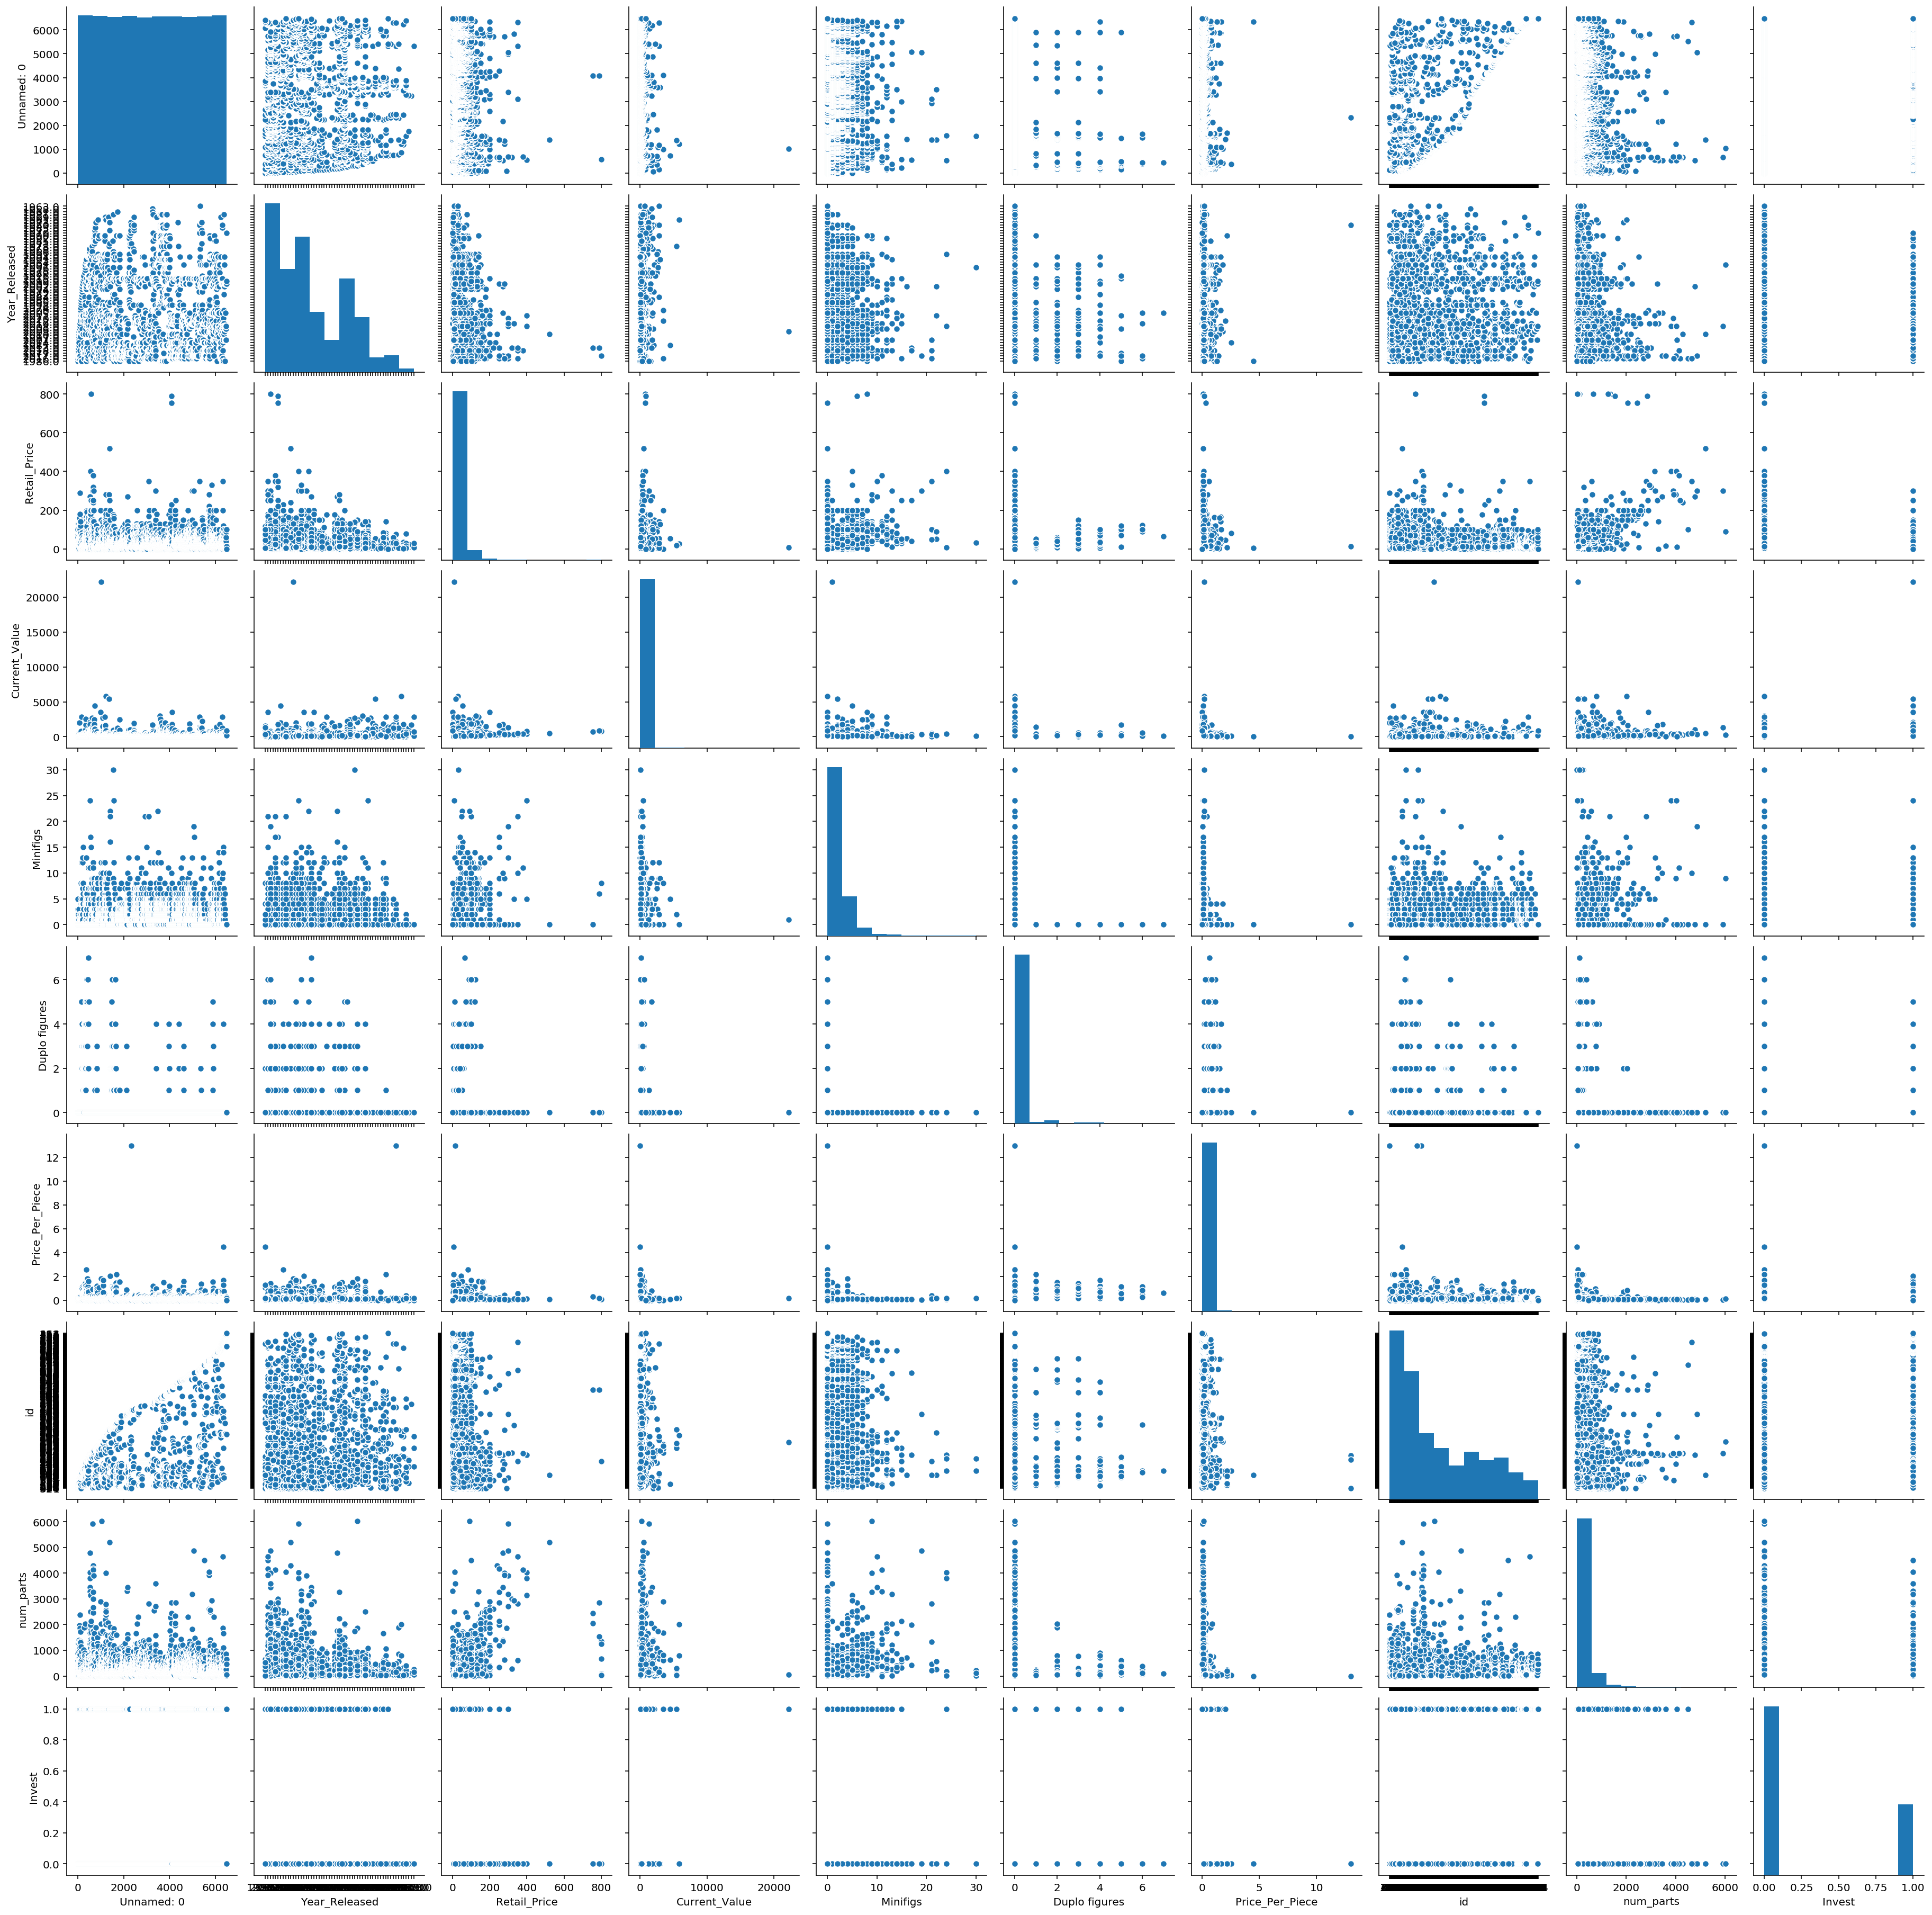

In [201]:
sns.pairplot(model_df);

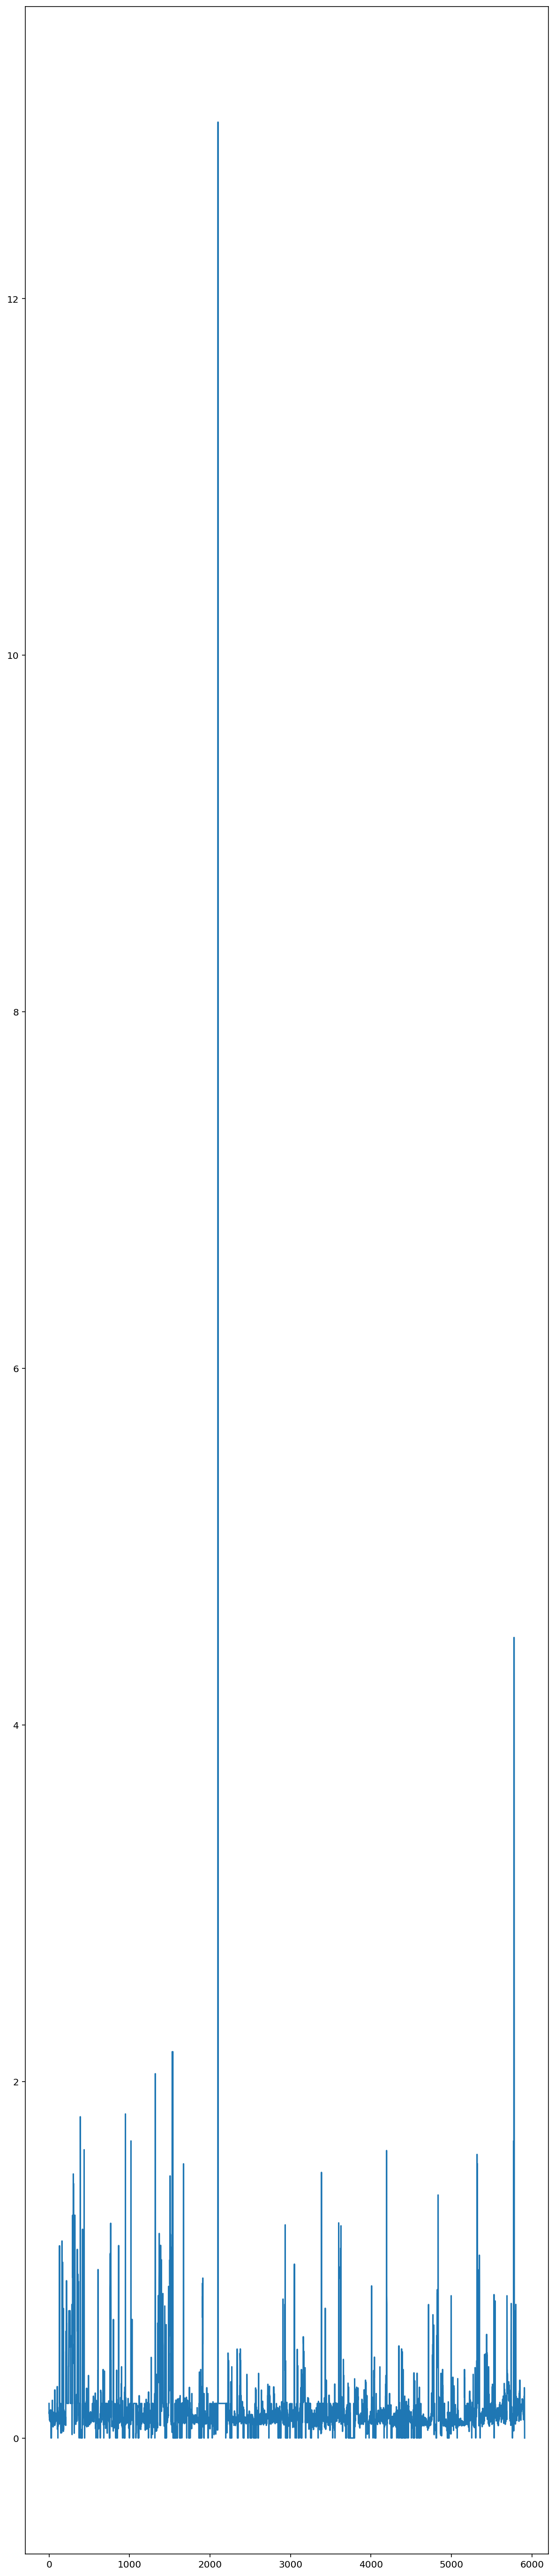

In [135]:
plt.plot(model_df.Price_Per_Piece)

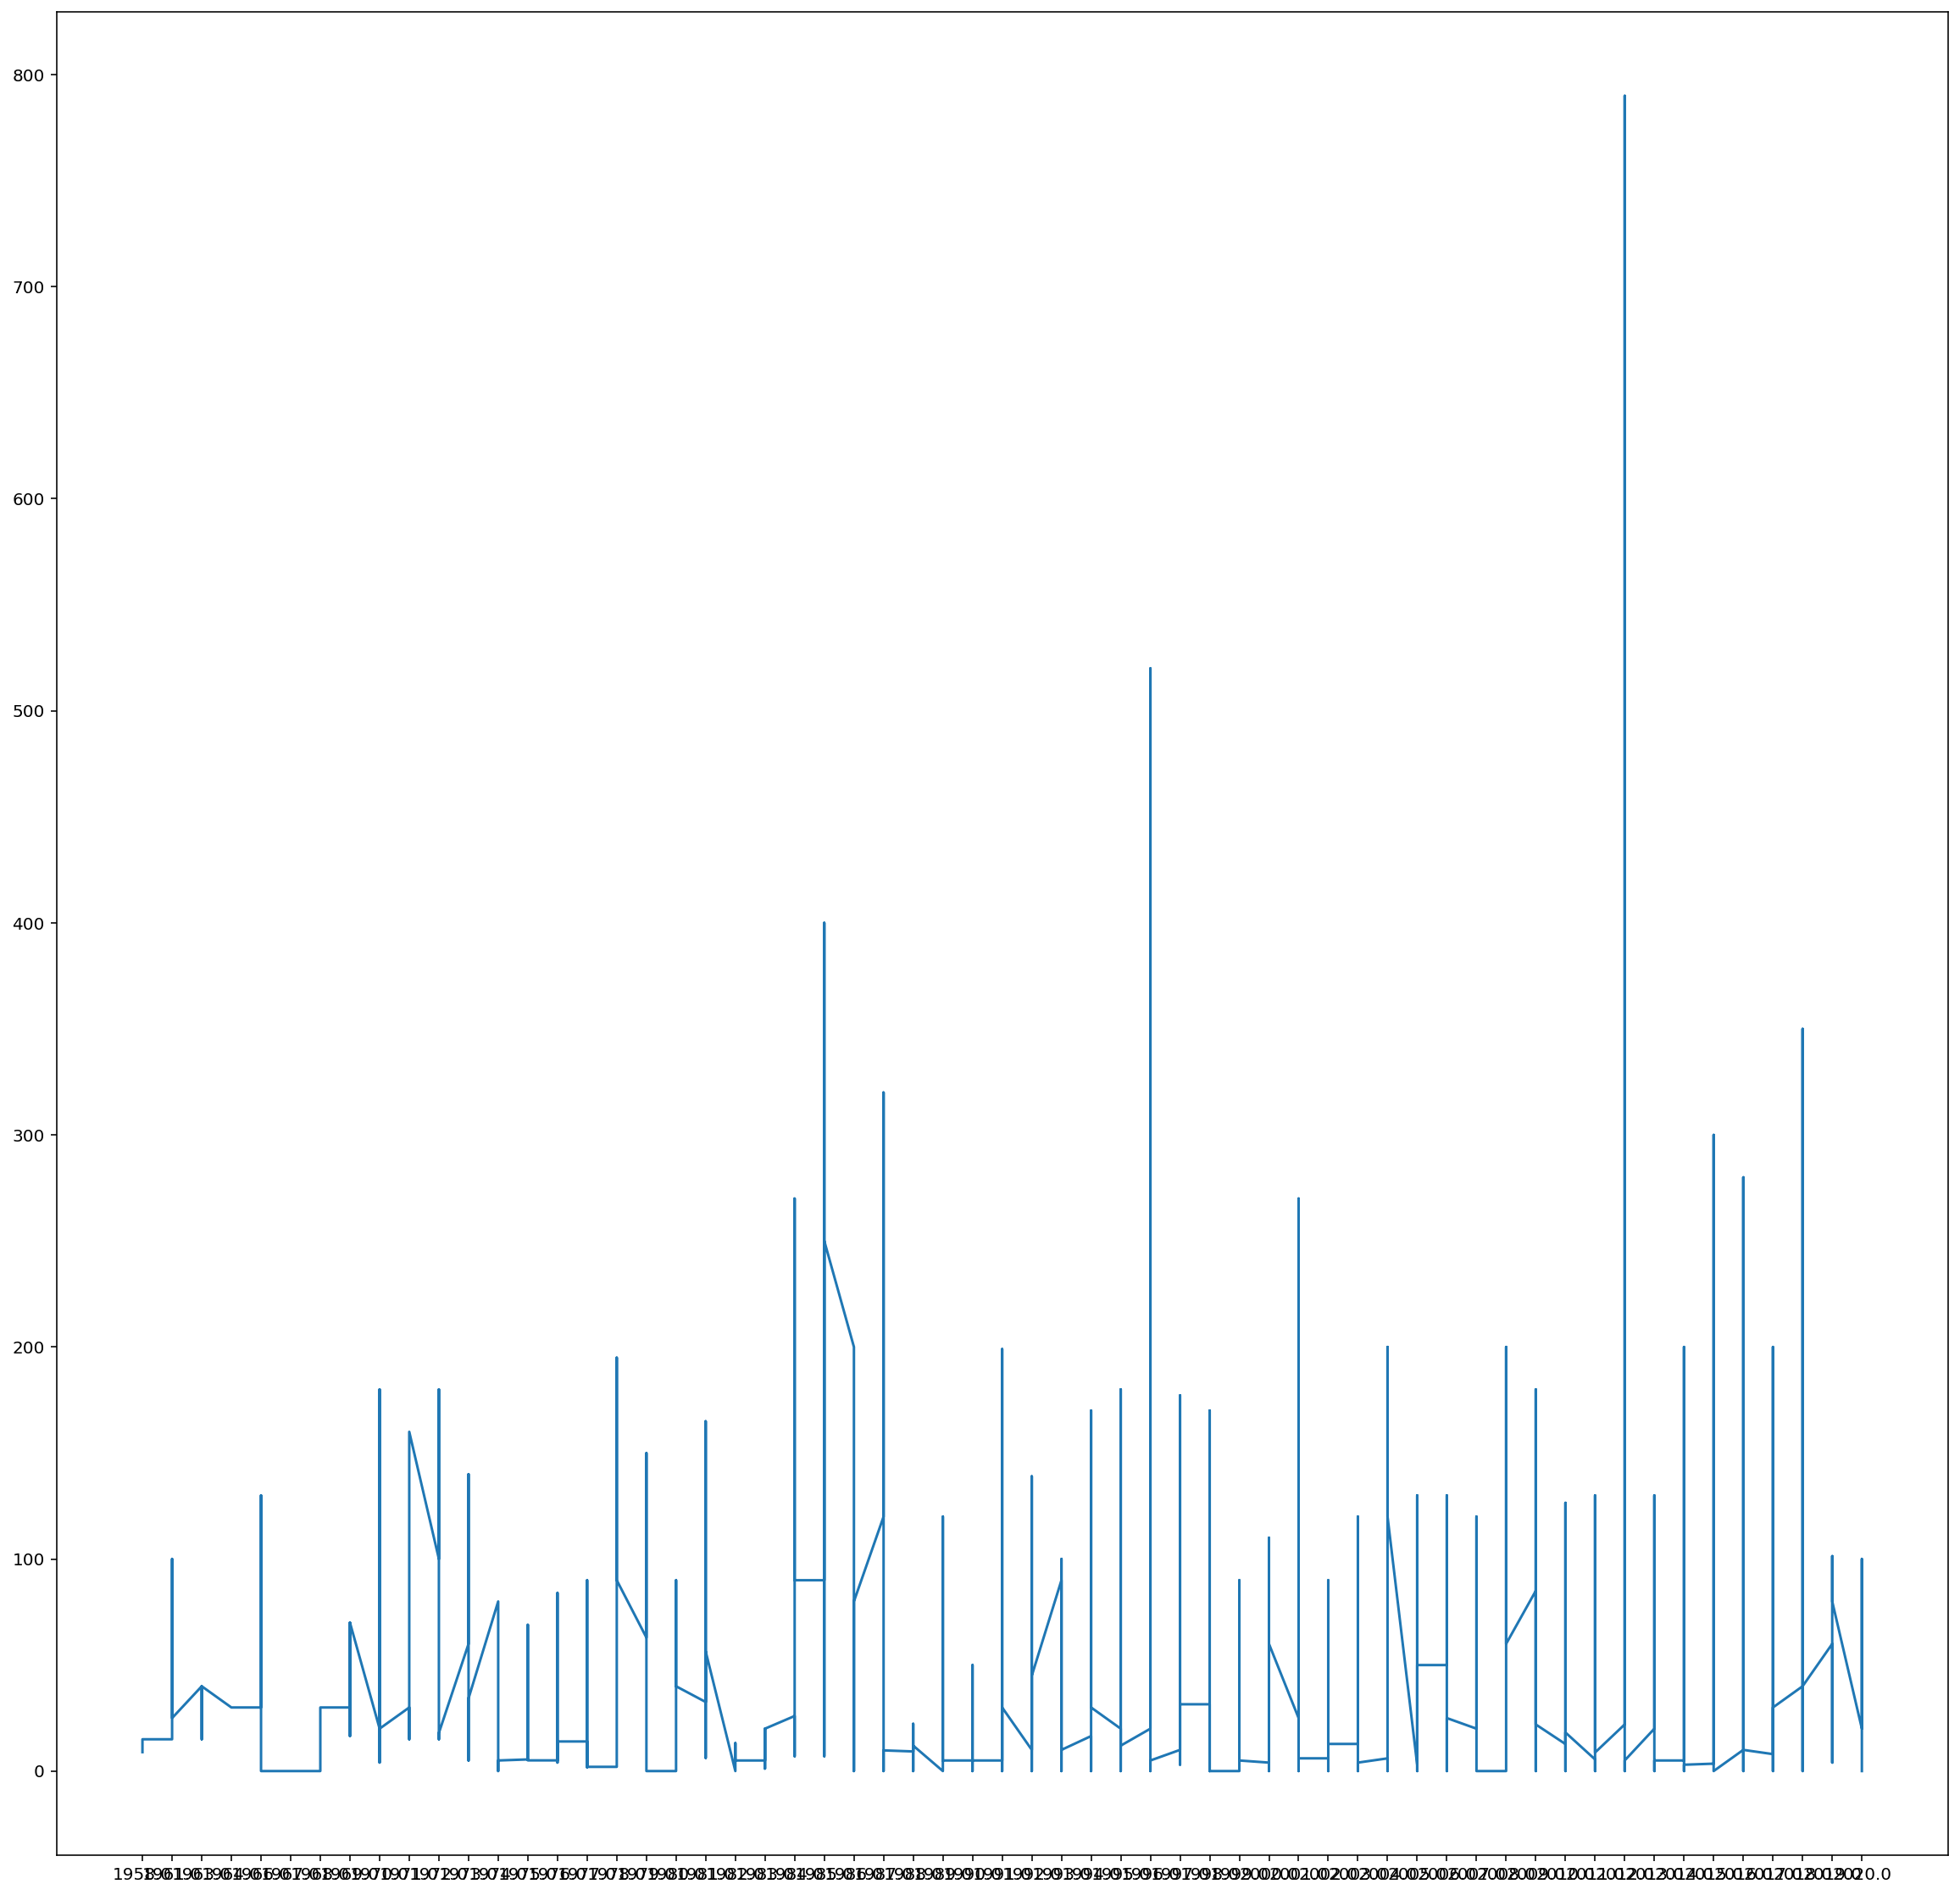

In [119]:
plt.plot(sorted(model_df.Year_Released), model_df.Retail_Price)

In [120]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [121]:
def log_reg(X_train, y_train, X_test, y_test, solver_val='lbfgs'):  
    lr = LogisticRegression(solver=solver_val)
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_pred, y_test), y_pred, model

In [122]:
def knn_classifier(X,y,X_test,y_test,neigh = 5):
    knn = KNeighborsClassifier(n_neighbors=neigh)
    model = knn.fit(X, y)
    y_pred = model.predict(X_test)
    return y_pred, model

In [ ]:
def knn_classifier(X,y,X_test, y_test, neighbors=5, weight='uniform', algo='auto', leaf=30, power=2)
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights=weight, algorithm=algo, leaf_size=leaf, p=power )
    model = knn.fit(X, y)
    y_pred = model.predict(X_test)
    return y_pred, model

In [123]:
def random_forest_classifier(X_train, y_train,X_test, y_test, estimators = 100, features = 10):
    rc = RandomForestClassifier(n_estimators = estimators)
    model = rc.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, model

In [124]:
def naive_bayes(X_train, y_train,X_test, y_test, model = 'g'):
    """ To select model, use g for guassianNB, b for bernoulliNB, and m for multinomialNB"""
    if model == 'g':
        nb = GaussianNB()
    elif model == 'm':
        nb = MultinomialNB()
    elif model == 'b':
        nb = BernoulliNB()
    else: 
        raise ValueError('Model selection was not corret.  Use, "b" "m", or "g"')
    model = nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    return nb.score(X_test, y_test), y_pred, model

In [125]:
def svm_classifier(X,y,X_test,y_test,kernal_type = 'linear'):
    model_svm = svm.SVC(kernel= kernal_type)
    model = model_svm.fit(X, y)
    y_pred = model_svm.predict(X_test)
    return model, y_pred

In [126]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   5910 non-null   object 
 1   Theme                  5910 non-null   object 
 2   Subtheme               5910 non-null   object 
 3   Year_Released          5910 non-null   object 
 4   Availability           5910 non-null   object 
 5   Retail_Price           5910 non-null   float64
 6   Current_Value          5910 non-null   float64
 7   Current_Sets_For_Sale  5910 non-null   object 
 8   Years                  5910 non-null   object 
 9   Minifigs               5910 non-null   float64
 10  Duplo figures          5910 non-null   float64
 11  Price_Per_Piece        5910 non-null   float64
 12  set_num                5910 non-null   object 
 13  id                     5910 non-null   object 
 14  num_parts              5910 non-null   int64  
 15  Inve

In [99]:
def split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['Name'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['Name'].isin(test_users)]
    df_te = df[df['Name'].isin(test_users)] 

    y_tr, y_te = df_tr['Invest'], df_te['Invest']
    X_tr = df_tr.drop(['Invest','Current_Value','Name','Theme', 'Subtheme', 'Year_Released', 'Availability','Current_Sets_For_Sale','set_num', 'id', 'Years'],axis=1) 
    X_te = df_te.drop(['Invest','Name','Current_Value','Theme', 'Subtheme', 'Year_Released', 'Availability','Current_Sets_For_Sale','set_num', 'id', 'Years'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [100]:
X_tr, X_te, y_tr, y_te = split_data(model_df)

In [101]:
score, y_pred, na_ba = naive_bayes(X_tr, y_tr, X_te, y_te)
score

0.4965576592082616

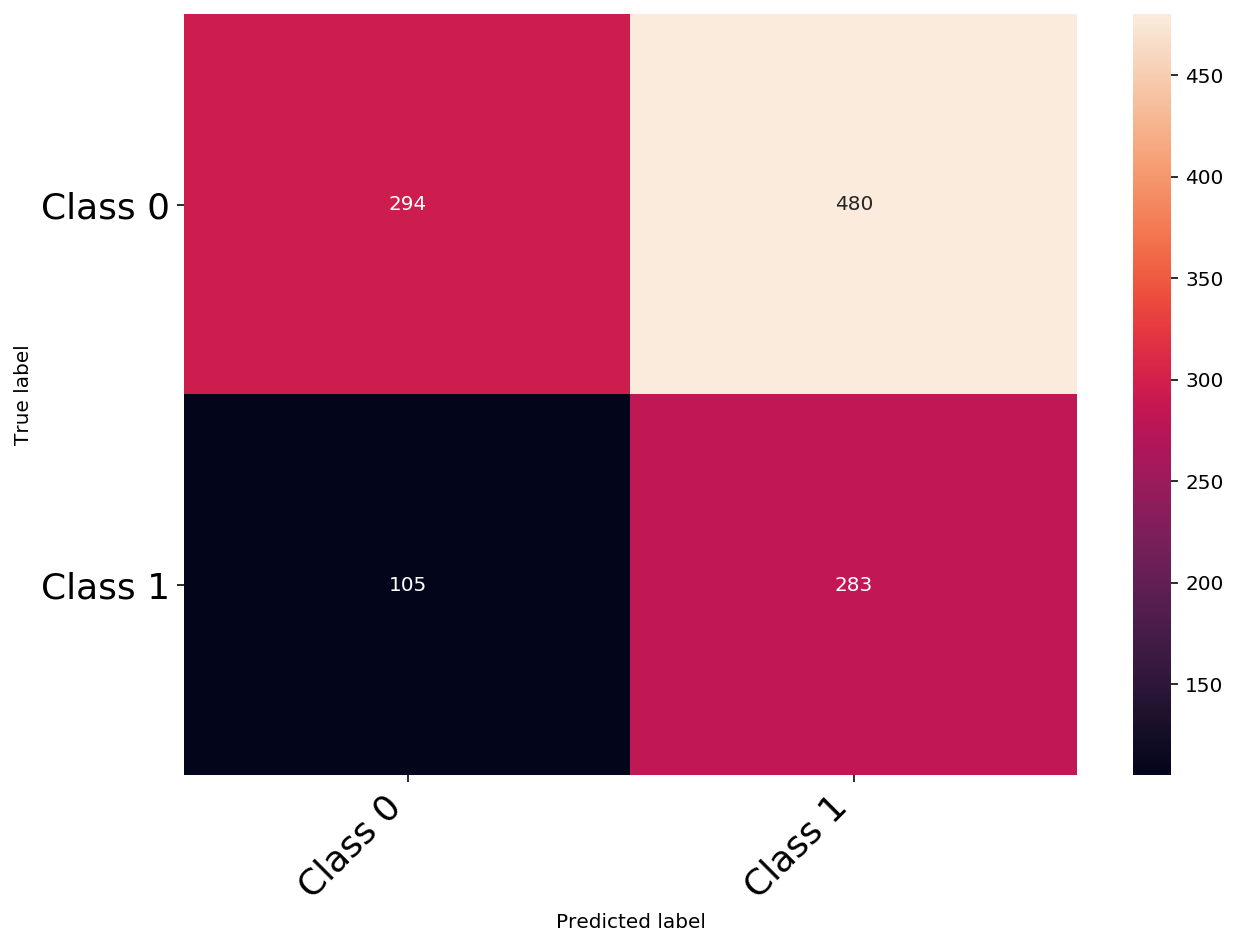

In [102]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_pred), ['Class 0', 'Class 1'])

In [103]:
y_pred, rand_forest = random_forest_classifier(X_tr, y_tr, X_te, y_te)


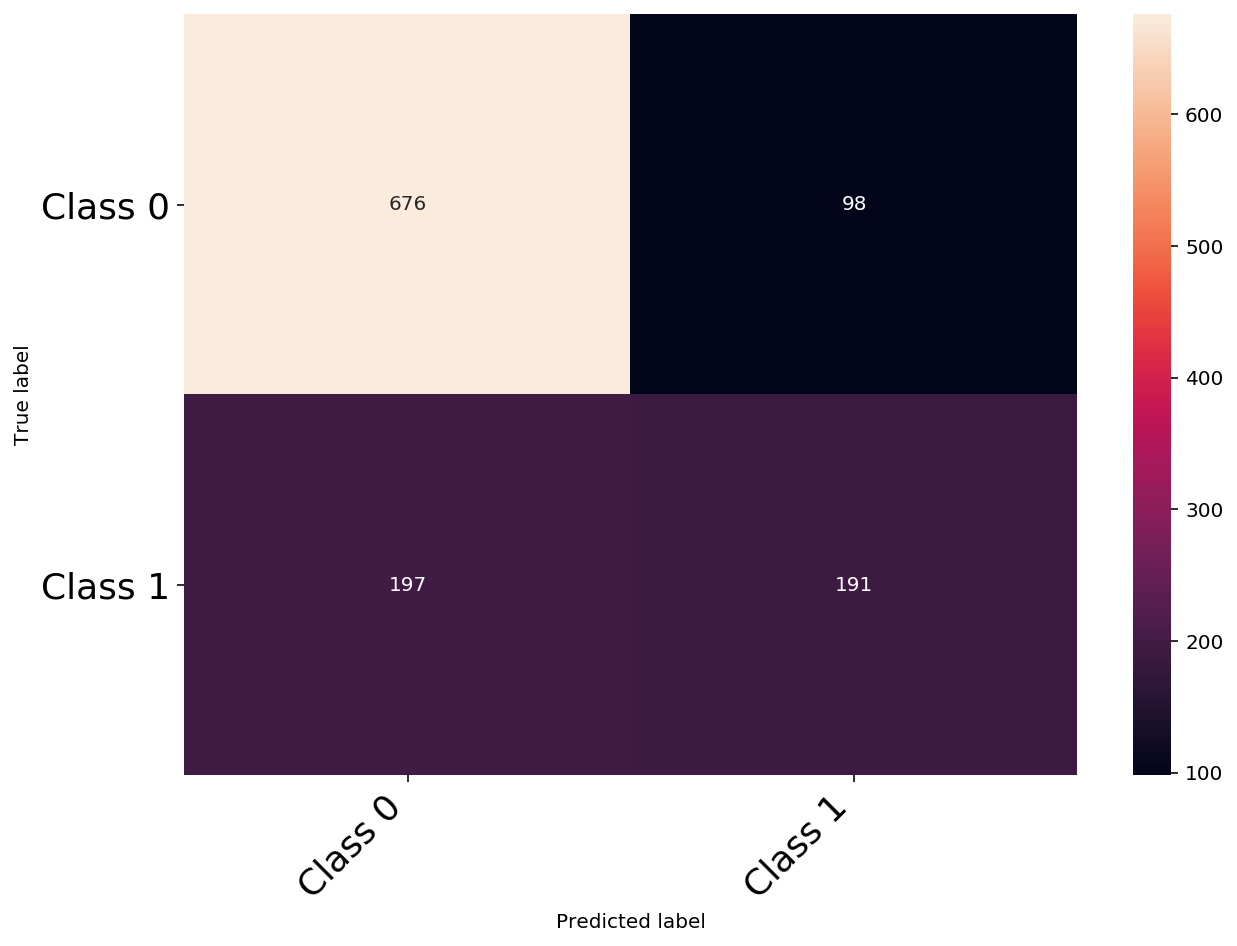

In [104]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_pred), ['Class 0', 'Class 1'])

In [105]:
score, y_pred, knn1 = knn_classifier(X_tr, y_tr, X_te, y_te)
score

0.48575712143928046

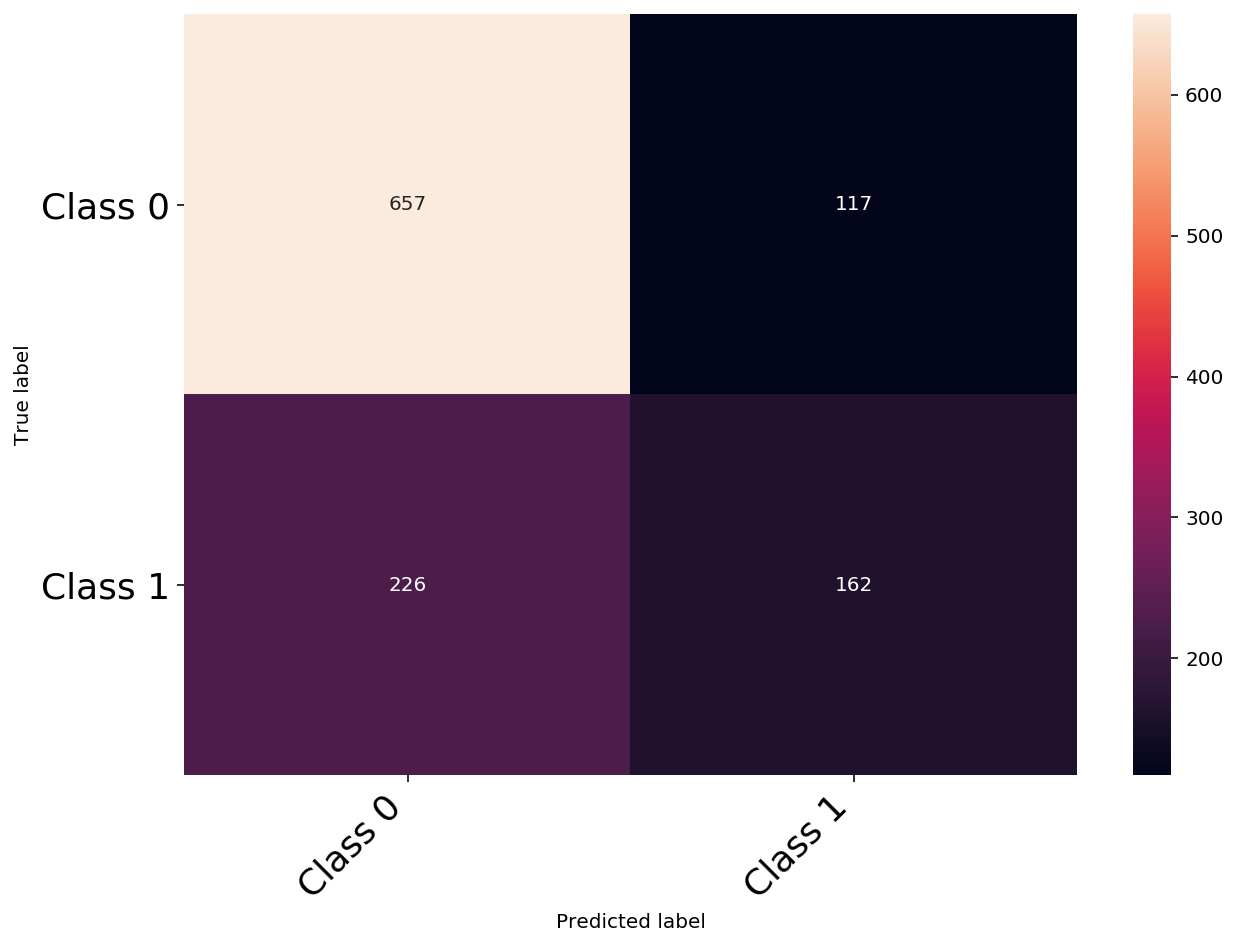

In [106]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_pred), ['Class 0', 'Class 1'])

In [107]:
data_dmatrix = xgb.DMatrix(data=X_tr, label=y_tr)

In [108]:
params = {"objective":"binary:hinge", "colsample_bytree": 0.5, "learning_rate": 0.3, "max_depth": 5, "alpha": 5}

cv_results = xgb.cv(dtrain = data_dmatrix, 
                    params = params, 
                    nfold = 3,
                    num_boost_round = 50,
                    early_stopping_rounds = 10,
                    metrics = "rmse",
                    as_pandas = True,
                    seed = 123
                   )

In [109]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.825175,0.002057,0.825167,0.004104
1,0.806590,0.025135,0.811232,0.022361
2,0.717361,0.025705,0.730723,0.024169
3,0.612043,0.028665,0.623839,0.029864
4,0.511225,0.020999,0.523221,0.015887


In [110]:
print((cv_results['test-rmse-mean']).tail(1))

49    0.476247
Name: test-rmse-mean, dtype: float64


In [111]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

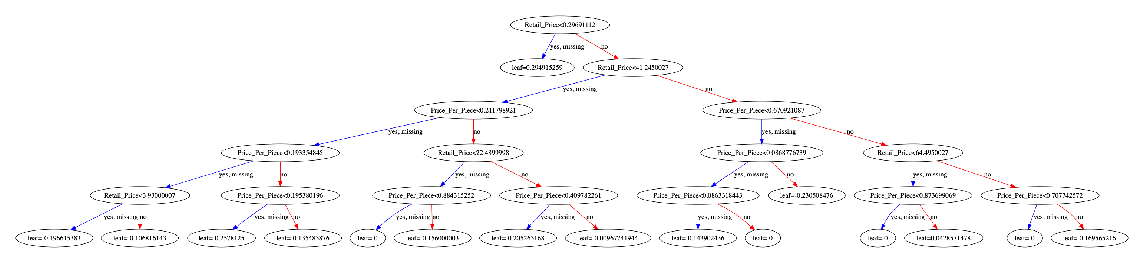

In [131]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [10, 50]
plt.show()

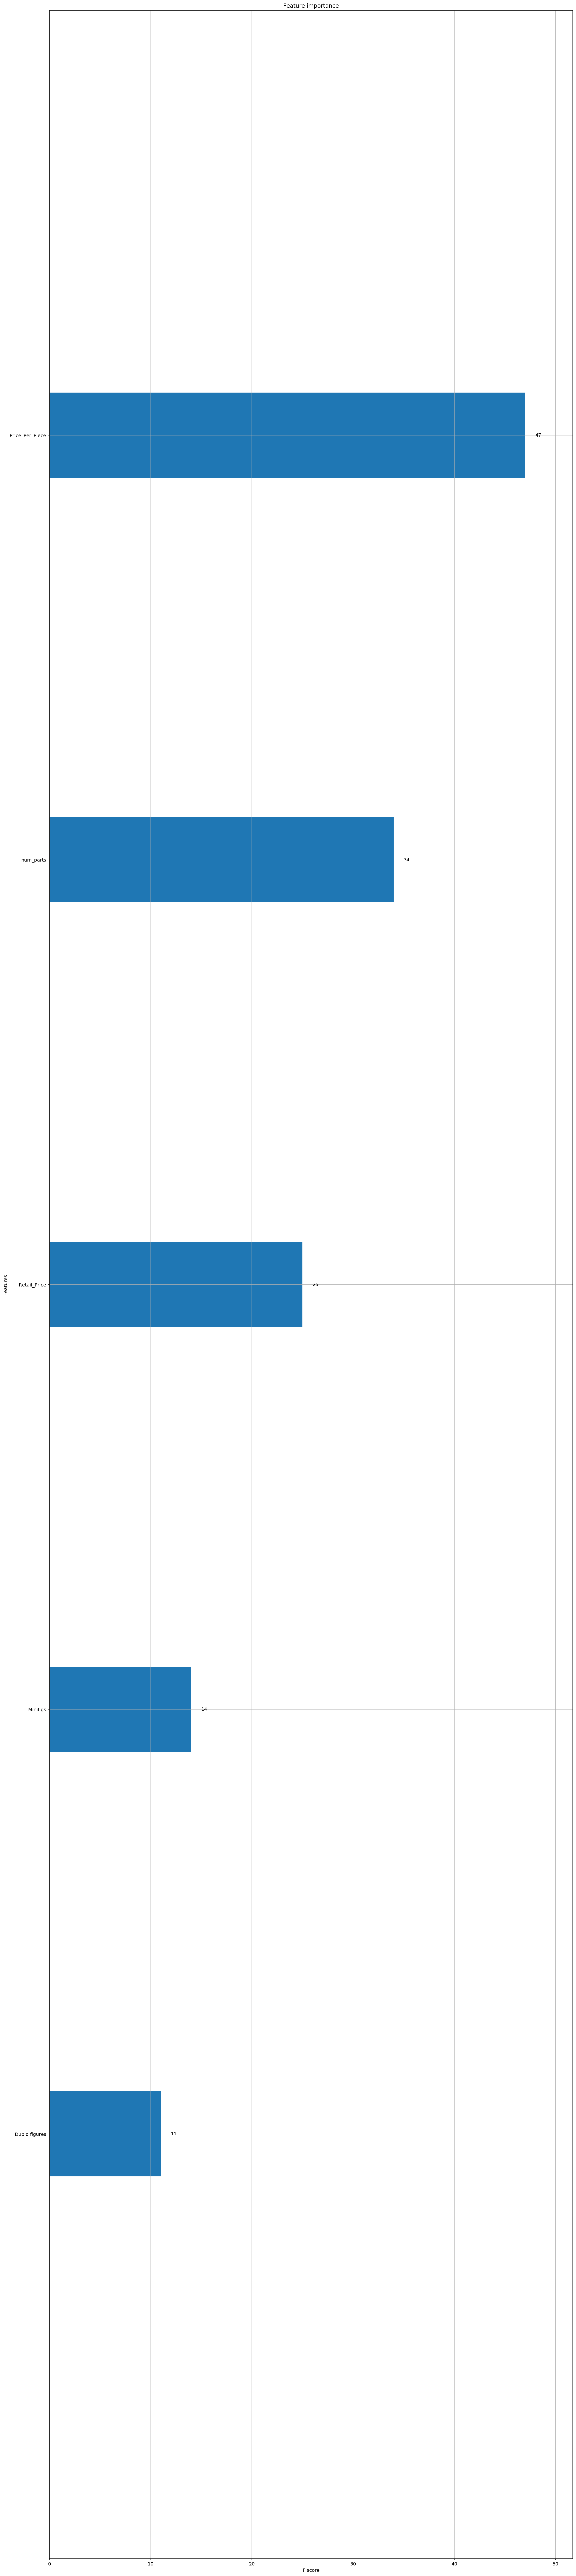

In [113]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size = 0.2, random_state = 123)

In [79]:
xg_reg = xgb.XGBRegressor(objective = 'binary:hinge', 
                          colsample_bytree = .5, 
                          learning_rate = .3, 
                          max_depth = 3, 
                          alpha = 5, 
                          n_estimators = 5)

In [80]:
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5,
             n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [84]:
preds = xg_reg.predict(X_te)

In [85]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
preds

RMSE: 0.509801


array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

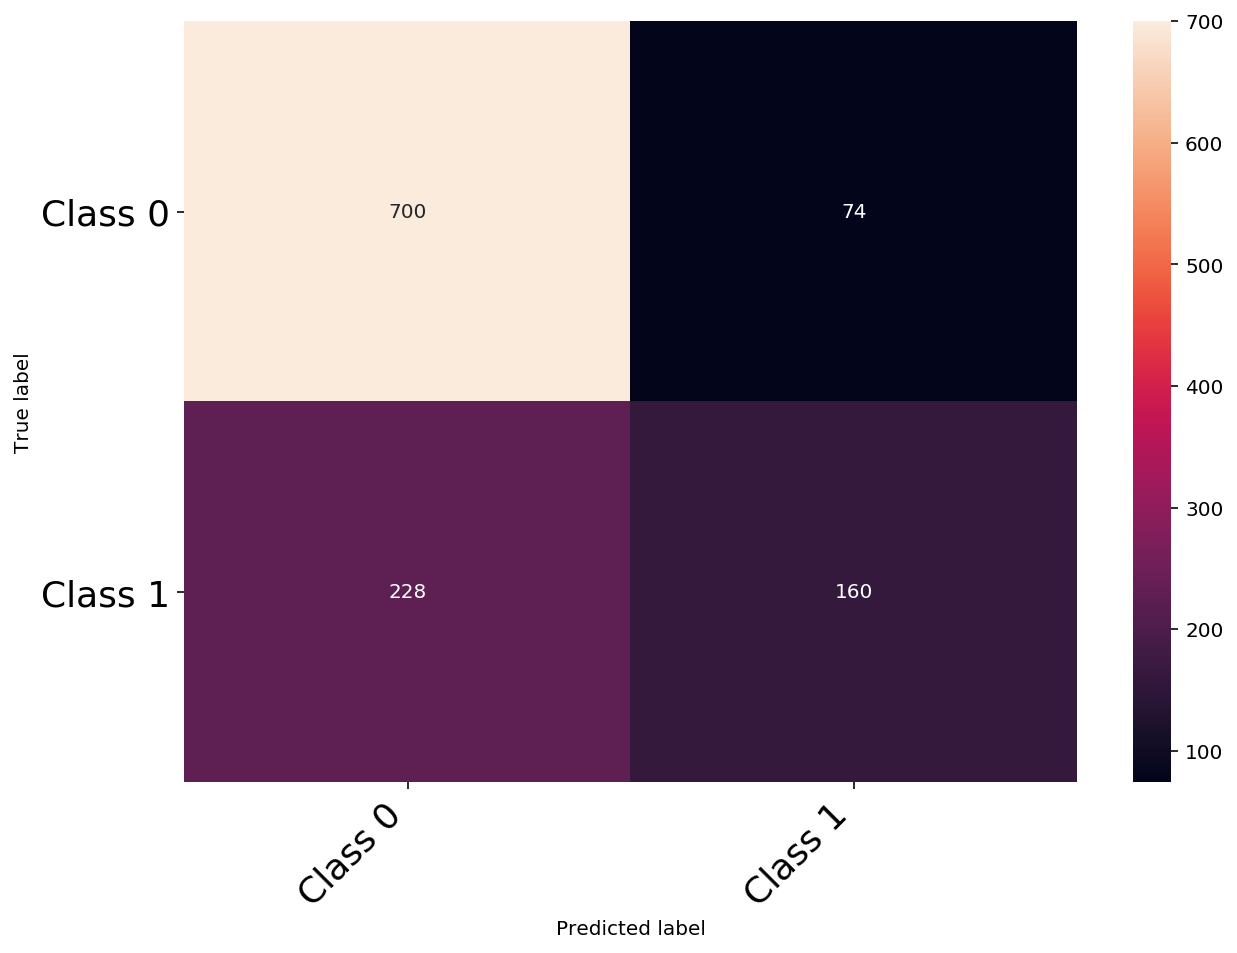

In [87]:
cm = print_confusion_matrix(confusion_matrix(y_test, preds), ['Class 0', 'Class 1'])